<>:10: SyntaxWarning: invalid escape sequence '\A'
<>:10: SyntaxWarning: invalid escape sequence '\A'
C:\Users\mdraf\AppData\Local\Temp\ipykernel_18744\1763389636.py:10: SyntaxWarning: invalid escape sequence '\A'
  AUDIO_FILE_PATH = "B:\AAUB 22024010 7th\AVE 4701\Lab\Audio Fingerprinting\Dataset\ONE_OK_ROCK_SAVE_YOURSELF_OFFICIAL_VIDEO_Fueled_By_Ramen.wav"


Successfully loaded file. Sampling Rate (sr): 10000.0 Hz
Note: Converted stereo audio to mono (left channel).
Signal length: 1979760 samples


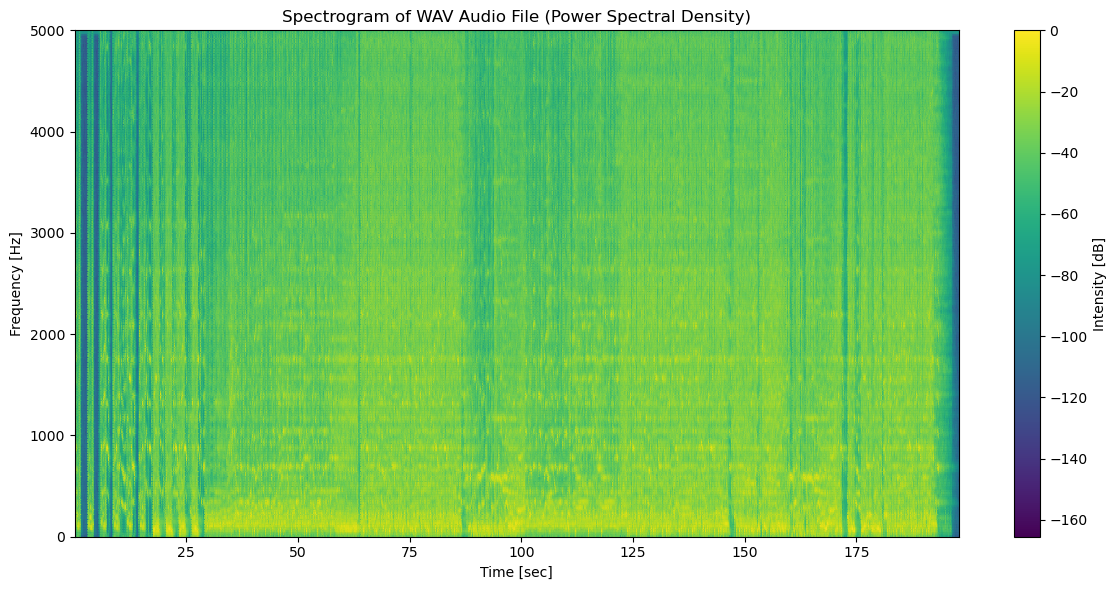

In [36]:
import numpy as np
from scipy.io import wavfile
from scipy import signal
import matplotlib.pyplot as plt
import librosa
from scipy.signal import resample

# --- 1. Audio Loading (Input File) ---
# NOTE: Replace 'your_audio_file.wav' with the actual path to your WAV file.
AUDIO_FILE_PATH = "B:\AAUB 22024010 7th\AVE 4701\Lab\Audio Fingerprinting\Dataset\ONE_OK_ROCK_SAVE_YOURSELF_OFFICIAL_VIDEO_Fueled_By_Ramen.wav"

try:
    # Read the WAV file:
    # sr: Sampling rate (e.g., 44100 Hz)
    # data: Audio signal data (a NumPy array)
    sr, data = wavfile.read(AUDIO_FILE_PATH)

    tar_sr = 10e3
    num_tar_sample = int(len(data)*tar_sr/sr)
    data = resample(data, num_tar_sample)
    sr= tar_sr

    print(f"Successfully loaded file. Sampling Rate (sr): {sr} Hz")
    
    # If the audio is stereo (2 channels), use only the first channel (mono)
    if data.ndim > 1:
        y = data[:, 0]  # Take the left channel
        print("Note: Converted stereo audio to mono (left channel).")
    else:
        y = data
    
    # y = y[:len(y)//4]
    
    print(f"Signal length: {y.shape[0]} samples")


except FileNotFoundError:
    print(f"Error: WAV file not found at {AUDIO_FILE_PATH}")
    exit()
except Exception as e:
    print(f"Error reading WAV file: {e}")
    exit()


nperseg_val = int(sr * 0.04)   # Segment length (e.g., 40ms)
noverlap_val = int(sr * 0.02)  # Overlap length (e.g., 20ms)


f, t_spec, Sxx = signal.spectrogram(
    y,
    fs=sr,
    window='hann',
    nperseg=nperseg_val,
    noverlap=noverlap_val,
    scaling='density'
)

Sxx = Sxx/np.max(Sxx)  # Normalize Sxx to [0, 1]

Sxx_db = 10 * np.log10(Sxx, out=np.full_like(Sxx, -100.0), where=Sxx>0)

plt.figure(figsize=(12, 6))


plt.pcolormesh(t_spec, f, Sxx_db, shading='gouraud', cmap='viridis')

plt.title('Spectrogram of WAV Audio File (Power Spectral Density)')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Intensity [dB]')
plt.ylim(0, sr / 2) # Show frequencies up to the Nyquist frequency
plt.tight_layout()
plt.show()

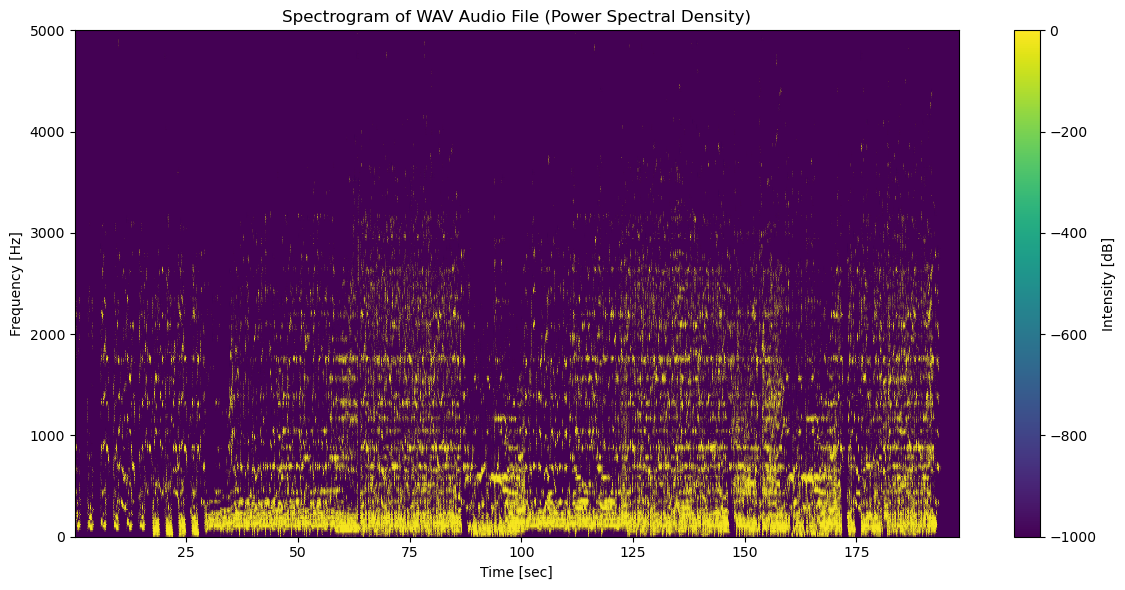

In [84]:
threshold = np.average(np.sort(Sxx.flatten())[-int(Sxx.size*0.1)])  # Keep top 1000 values
Sxx_filtered = np.where(Sxx >= threshold, Sxx, 0)
Sxx_filtered = 10 * np.log10(Sxx_filtered, out=np.full_like(Sxx_filtered, -100.0), where=Sxx_filtered>0)

plt.figure(figsize=(12, 6))


plt.pcolormesh(t_spec, f, Sxx_filtered, shading='gouraud', cmap='viridis')

plt.title('Spectrogram of WAV Audio File (Power Spectral Density)')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Intensity [dB]')
plt.ylim(0, sr / 2) # Show frequencies up to the Nyquist frequency
plt.tight_layout()
plt.show()


In [82]:
cols = Sxx_filtered.shape[1]
window_cols = cols//30
print(f"Total columns: {cols}, Window columns: {window_cols}")
marker = np.zeros_like(Sxx_filtered)

for i in range(0, cols - window_cols, window_cols):

    window = Sxx_filtered[:, i:i + window_cols]
    k = int(window.size*2e-4)
    top_value_indexes = np.argpartition(window.flatten(), -k)[-k:]
    r, c = np.unravel_index(top_value_indexes, window.shape)
    marker[r, c + i] = 1


row_indices, col_indices = np.where(marker == 1)
freq_coords = f[row_indices]
time_coords = t_spec[col_indices]

Total columns: 9897, Window columns: 329


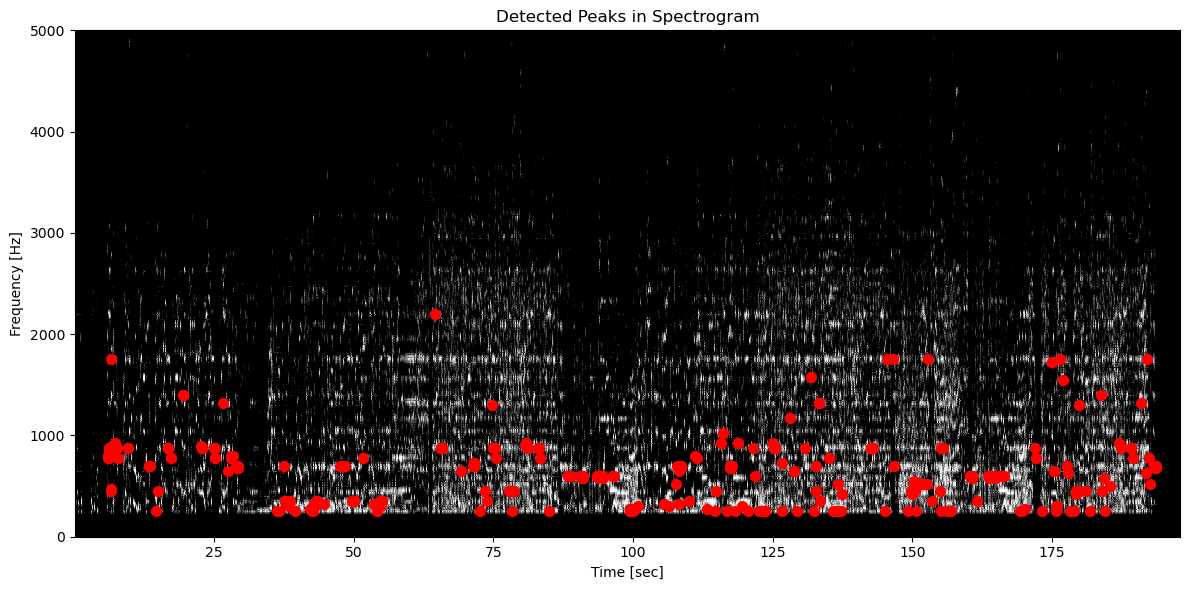

In [83]:
plt.figure(figsize=(12, 6))
plt.pcolormesh(t_spec, f, Sxx_filtered, shading='gouraud', cmap='gray')
plt.scatter(time_coords, freq_coords, c='red', s=50)
plt.title('Detected Peaks in Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, sr / 2) # Show frequencies up to the Nyquist
plt.tight_layout()
plt.show()

In [ ]:
def cfar(data, num_train, num_guard, rate_fa):

    row, col = data.shape
    n = data.size
    detections = np.zeros(n)
    alpha = num_train * (rate_fa ** (-1 / num_train) - 1)  

    data = np.abs(data.flatten())
    data = data / np.max(data)
    data = np.pad(data, (num_train + num_guard, num_train + num_guard), 'constant', constant_values=(0, 0))

    for i in range(num_train + num_guard, n - num_train - num_guard):

        start_train = i - num_guard - num_train
        end_train = i + num_guard + num_train + 1
        
        # Exclude guard cells
        training_cells = np.concatenate((data[start_train:i - num_guard], data[i + num_guard + 1:end_train]))
        
        # Estimate noise level
        noise_level = np.mean(training_cells)
        
        # Calculate threshold
        threshold = alpha * noise_level
        
        # Detect if the CUT exceeds the threshold
        if data[i] > threshold:
            detections[i] = data[i]
        
            
    return detections.reshape(row, col)

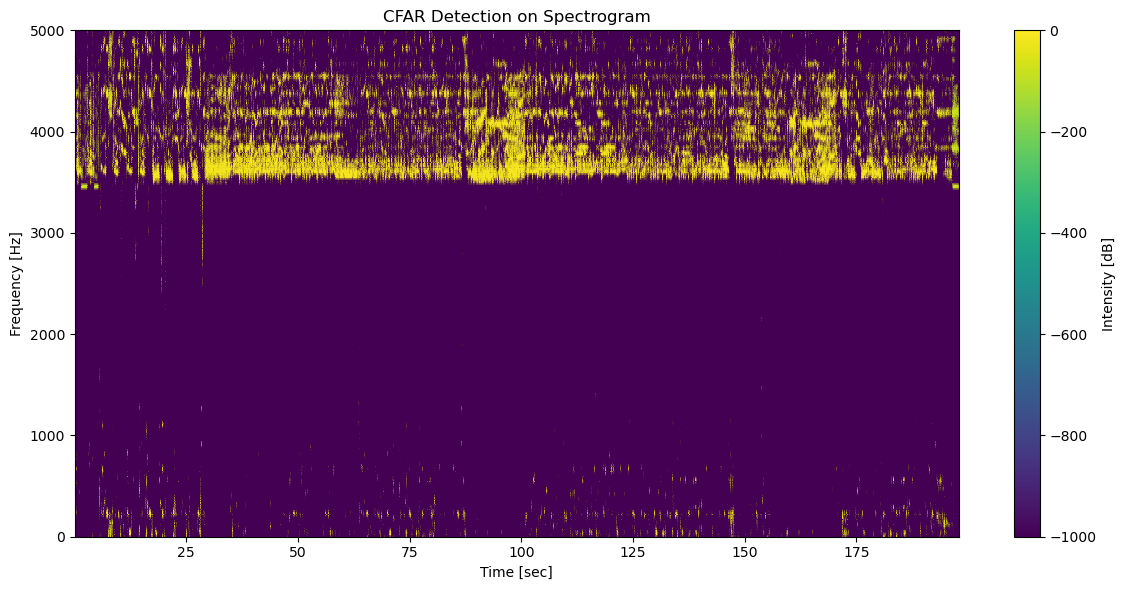

In [90]:
cfar_map = cfar(Sxx, num_train=100, num_guard=40, rate_fa=1e-3)
cfar_map_db = 10 * np.log10(cfar_map, out=np.full_like(cfar_map, -100.0), where=cfar_map>0)

plt.figure(figsize=(12, 6))
plt.pcolormesh(t_spec, f, cfar_map_db, shading='gouraud', cmap='viridis')
plt.title('CFAR Detection on Spectrogram')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Intensity [dB]')
plt.ylim(0, sr / 2) # Show frequencies up to the Nyquist frequency
plt.tight_layout()
plt.show()